 # Dealing with Class Imbalance with SMOTE

### In this kernel, I will use a simple Deep Learning model and compare its performance on normal data and data augmented with SMOTE

> Check https://arxiv.org/pdf/1106.1813.pdf

I use SMOTE to add **sentence level** noise to our data.

#### The model is the following one :
* GloVe Embedding
* Bidirectional GRU
* MaxPool
* Dense 
* Probably some Dropouts


#### Feel free to give any feedback, it is always appreciated.

In [55]:
import numpy as np
import pandas as pd
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from collections import Counter

## How does SMOTE work ?

> " The minority class is over-sampled by taking each minority class sample and introducing synthetic examples along the line segments joining any/all of the k minority class nearest neighbors "

> " Synthetic samples are generated in the following way: Take the diﬀerence between the feature vector (sample) under consideration and its nearest neighbor. Multiply this diﬀerence by a random number between 0 and 1, and add it to the feature vector under consideration. This causes the selection of a random point along the line segment between two speciﬁc features. This approach eﬀectively forces the decision region of the minority class to become more general. "

I am using the class from imblearn,  see https://imbalanced-learn.org/en/stable/generated/imblearn.over_sampling.SMOTE.html

In [56]:
from imblearn.over_sampling import SMOTE

In [57]:
sum([0.2, 0.6, 0.15, 0.05])

1.0

In [58]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=600, n_features=4, n_informative=4, n_redundant=0, n_classes=4, weights=[0.2, 0.6, 0.15, 0.05], class_sep=0.95, random_state=0)

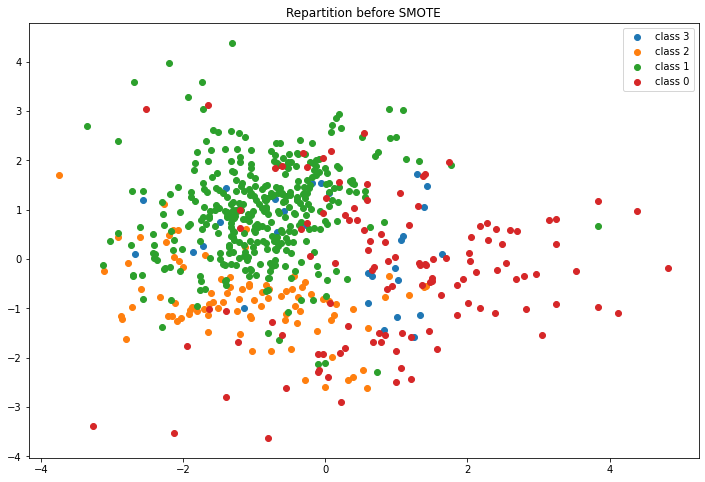

In [59]:
plt.figure(figsize=(12, 8))
plt.title('Repartition before SMOTE')
plt.scatter(X[y==3][:, 0], X[y==3][:, 1], label='class 3')
plt.scatter(X[y==2][:, 0], X[y==2][:, 1], label='class 2')
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], label='class 1')
plt.scatter(X[y==0][:, 0], X[y==0][:, 1], label='class 0')
plt.legend()
plt.grid(False)
plt.show()

In [60]:
smt = SMOTE()
X_smote, y_smote = smt.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


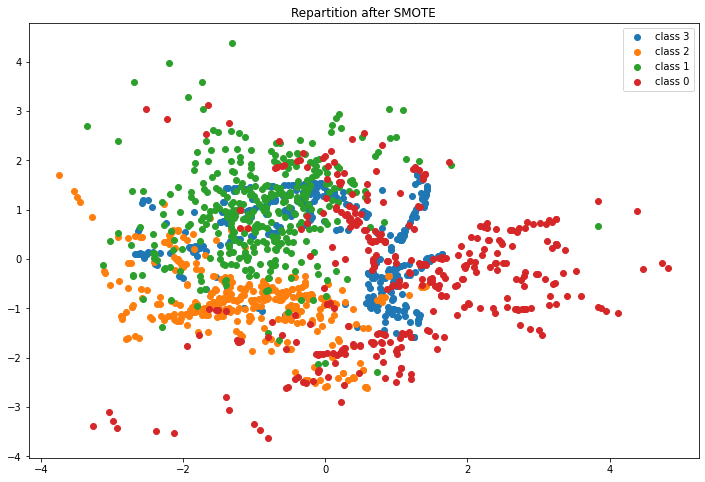

In [61]:
plt.figure(figsize=(12, 8))
plt.title('Repartition after SMOTE')
plt.scatter(X_smote[y_smote==3][:, 0], X_smote[y_smote==3][:, 1], label='class 3')
plt.scatter(X_smote[y_smote==2][:, 0], X_smote[y_smote==2][:, 1], label='class 2')
plt.scatter(X_smote[y_smote==1][:, 0], X_smote[y_smote==1][:, 1], label='class 1')
plt.scatter(X_smote[y_smote==0][:, 0], X_smote[y_smote==0][:, 1], label='class 0')
plt.legend()
plt.grid(False)
plt.show()

## Loading data

In [62]:
df = pd.read_csv("./data/Train_process.csv")
print("Number of texts: ", df.shape[0])

Number of texts:  616


In [63]:
df.head()

,ID,text,label
0,SUAVK39Z,i feel that it was better i die am happy,Depression
1,9JDAGUV3,why do i get hallucinations ?,Drugs
2,419WR1LQ,i am stressed due to lack of financial support...,Depression
3,6UY7DX6Q,why is life important ?,Suicide
4,FYC0FTFB,how could i be helped to go through the depres...,Depression


In [64]:
df = df.sample(616)

In [65]:
df.head()

,ID,text,label
313,J3ORYNFV,i felt emotionally low and sad most of the tim...,Depression
413,4AEMAVSI,why is alcohol sold along the school perimeter,Alcohol
441,1NYXESRZ,how can i be helped to heal from depression,Depression
412,N5NIMS0Z,hopeless,Depression
150,UVSIAT7E,i feel like giving up everything,Depression


## Class imbalance

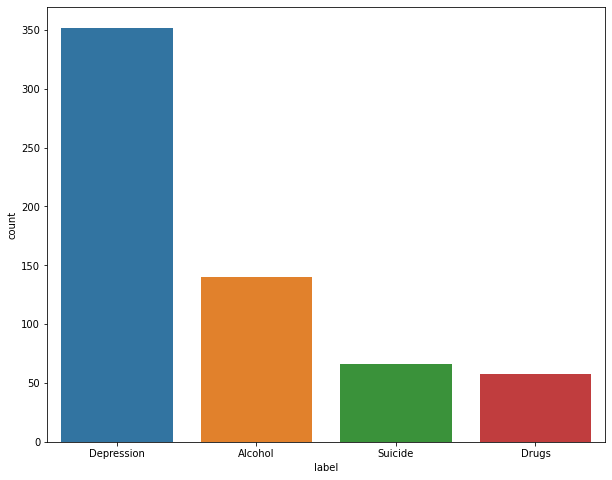

In [66]:
plt.figure(figsize = (10, 8))
sns.countplot(df['label'])
plt.show()

In [67]:
print(Counter(df['label']))

Counter({'Depression': 352, 'Alcohol': 140, 'Suicide': 66, 'Drugs': 58})


There is way more 0s than 1s in our dataset, data is very unbalanced and one should consider using oversampling or undersampling.

I don't recommand undersampling in Kaggle competitions, because you want to have as much data as possible for your training. 

## Making Data for the network
We apply the following steps :
* Splitting
* Tokenizing
* Padding

In [68]:
max_len = 50
len_voc = 620

### Train/Test split
It is important to split before oversampling ! 

In [69]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.5)

### Tokenizing

In [70]:
def make_tokenizer(texts, len_voc):
    from keras.preprocessing.text import Tokenizer
    t = Tokenizer(num_words=len_voc)
    t.fit_on_texts(texts)
    return t

In [71]:
tokenizer = make_tokenizer(df['text'], len_voc)

In [72]:
X_train = tokenizer.texts_to_sequences(df_train['text'])
X_test = tokenizer.texts_to_sequences(df_test['text'])

### Padding

In [73]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

### Targets

In [74]:
y_train = df_train['label'].values
y_test = df_test['label'].values

### Embeddings

In [75]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

def load_embedding(file):
    if file == './glove.6B.300d.txt':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
    return embeddings_index

In [76]:
def make_embedding_matrix(embedding, tokenizer, len_voc):
    all_embs = np.stack(embedding.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = tokenizer.word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    
    for word, i in word_index.items():
        if i >= len_voc:
            continue
        embedding_vector = embedding.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [77]:
glove = load_embedding('./glove.6B.300d.txt')

In [78]:
embed_mat = make_embedding_matrix(glove, tokenizer, len_voc)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [79]:
X_train_emb = embed_mat[X_train]
X_test_emb = embed_mat[X_test]

In [80]:
X_train_emb.shape

(308, 50, 300)

## Oversampling

In [81]:
train_size, max_len, embed_size = X_train_emb.shape
X_train_emb_r = X_train_emb.reshape(train_size, max_len*embed_size)

In [82]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(y_train)

y_train_ = le.transform(y_train)
# le.inverse_transform(y_) == train.label

In [83]:
SMOTE?

Init signature: SMOTE(*args, **kwargs)
Docstring:     
Class to perform over-sampling using SMOTE.

This object is an implementation of SMOTE - Synthetic Minority
Over-sampling Technique as presented in [1]_.

Read more in the :ref:`User Guide <smote_adasyn>`.

Parameters
----------
sampling_strategy : float, str, dict or callable, (default='auto')
    Sampling information to resample the data set.

    - When ``float``, it corresponds to the desired ratio of the number of
      samples in the majority class over the number of samples in the
      minority class after resampling. Therefore, the ratio is expressed as
      :math:`\alpha_{os} = N_{M} / N_{rm}` where :math:`N_{rm}` and
      :math:`N_{M}` are the number of samples in the minority class after
      resampling and the number of samples in the majority class,
      respectively.

        .. warning::
           ``float`` is only available for **binary** classification. An
           error is raised for multi-class classifica

In [84]:
# smt = SMOTE(sampling_strategy=0.2)
smote=SMOTE("not majority" )
X_smote, y_smote = smote.fit_sample(X_train_emb_r, y_train_)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [85]:
X_smote = X_smote.reshape((X_smote.shape[0], max_len, embed_size))

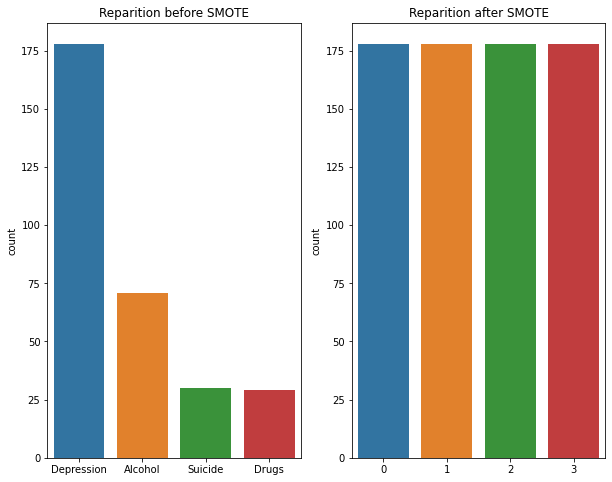

In [86]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
sns.countplot(y_train)
plt.title('Reparition before SMOTE')
plt.subplot(1, 2, 2)
sns.countplot(y_smote)
plt.title('Reparition after SMOTE')
plt.show()

In [87]:
X_smote.shape

(712, 50, 300)

## Now let us train a model

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymagnitude import *

from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import log_loss

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from keras.preprocessing.text import Tokenizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import ipdb

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [54]:
X_smote.shape

(688, 50, 300)

In [53]:
X = X_smote
y = y_smote

from sklearn.model_selection import KFold, StratifiedKFold

# kfold=KFold(n_splits=5)
kfold=StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


losses = []
acc = []
precision = []

for i, (train_index, validate_index) in enumerate(kfold.split(X, y)):
    #print("train index:", train_index, "validate index:", validate_index)
#     train_data_i = torch.utils.data.Subset(train_data, train_index)
#     validation_data_i = torch.utils.data.Subset(train_data, validate_index)
#     ipdb.set_trace()
    X_train = X[train_index]
    y_train = y[train_index]
    
    X_valid = X[validate_index]
    y_valid = y[validate_index]

#     models = [
#     RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
#     LinearSVC(),
#     MultinomialNB(),
#     LogisticRegression(random_state=0, solver='lbfgs'),
#     SVC(kernel='rbf', C=9, degree=9, max_iter=2000, probability=True), #'linear', 'poly', 'rbf', 'sigmoid'
#         ]
    
    models = [
            RandomForestClassifier(n_estimators=100, max_depth=100, random_state=0),
            LinearSVC(fit_intercept=True, intercept_scaling=2),
        #     MultinomialNB(),
            LogisticRegression(random_state=0),
            SVC(kernel='linear', C=1.0, degree=15, max_iter=1000), #'linear', 'poly', 'rbf', 'sigmoid'
            XGBClassifier(max_depth=2,
                          gamma=2,
                          eta=0.8,
                          reg_alpha=0.5,
                          reg_lambda=0.5),
            SGDClassifier(loss = 'log', alpha = 1e-4, 
                          n_jobs = -1, penalty = 'l2'),
            KNeighborsClassifier(n_jobs = -1),
            RandomForestClassifier(n_jobs = -1)]

    
    clf = models[-4].fit(X_train, y_train)
    
#     y_pred = clf.predict_proba(X_valid)
    
    
#     y_pred = clf._predict_proba_lr(X_valid)
    y_pred = clf.predict(X_valid)
    
#     ipdb.set_trace()
#     losses.append(log_loss(y_valid, y_pred))
    acc.append(accuracy_score(y_valid, y_pred))
    precision.append(precision_score(y_valid, y_pred, average='macro'))
    
#     print(f"Loss epoch {i+1} : {log_loss(y_valid, y_pred)}")
    print(f"Accuracy epoch {i+1} : {accuracy_score(y_valid, y_pred)}")
    print(f"Accuracy precision {i+1} : {precision_score(y_valid, y_pred, average='macro')}")
#     print("Number of Samples in Train: ",len(train))
#     print("Number of Samples in Valid: ",len(validation))

# print(f"\n#############################\nAverage loss {np.mean(losses)}")
print(f"\n#############################\nAverage loss {np.mean(acc)}")

ValueError: Input numpy.ndarray must be 2 dimensional

### Making model

In [48]:
from keras.models import Model
# from keras.layers import Dense, Bidirectional, GlobalMaxPool1D, Input, Dropout
from tensorflow.compat.v1.keras.layers import CuDNNGRU, Dense, Bidirectional, GlobalMaxPool1D, Input, Dropout
from keras.optimizers import Adam
from tensorflow.python.compiler.tensorrt import trt_convert as trt

In [49]:
def make_model(max_len, len_voc=50000, embed_size=300):
    inp = Input(shape=(max_len, 300))
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(inp)
    x = GlobalMaxPool1D()(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    return model

In [50]:
model = make_model(max_len)
model_smote = make_model(max_len)

AttributeError: 'tuple' object has no attribute 'layer'

In [86]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 50, 300)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 50, 1)             301       
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


### Callbacks

In [87]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=2, verbose=1, min_lr=0.000001)
checkpoints = ModelCheckpoint('weights.hdf5', monitor="val_acc", mode="max", verbose=True, save_best_only=True)

reduce_lr_smote = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=2, verbose=1, min_lr=0.000001)
checkpoints_smote = ModelCheckpoint('smote_weights.hdf5', monitor="val_acc", mode="max", verbose=True, save_best_only=True)

### Fitting

In [88]:
model.fit(X_train_emb, y_train, batch_size=128, epochs=3, validation_data=[X_test_emb, y_test], callbacks=[checkpoints, reduce_lr])

ValueError: Error when checking target: expected dense_2 to have 3 dimensions, but got array with shape (308, 1)

In [ ]:
model_smote.fit(X_smote, y_smote, batch_size=128, epochs=3, validation_data=[X_test_emb, y_test], callbacks=[checkpoints_smote, reduce_lr_smote])

In [ ]:
model.load_weights('weights.hdf5')
model_smote.load_weights('smote_weights.hdf5')

### Predictions

In [ ]:
pred_test = model.predict([X_test_emb], verbose=1)
pred_test_smote = model_smote.predict([X_test_emb], batch_size=256, verbose=1)

### Tweaking threshold

In [ ]:
def tweak_threshold(pred, truth):
    from sklearn.metrics import f1_score
    scores = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        score = f1_score(truth, (pred>thresh).astype(int))
        scores.append(score)
    return round(np.max(scores), 4)

In [ ]:
print(f"Scored {tweak_threshold(pred_test, y_test)} without SMOTE (test data)")

In [ ]:
print(f"Scored {tweak_threshold(pred_test_smote, y_test)} with SMOTE (test data)")

 ## Conclusion

It appears that SMOTE does not help improve the results. However, it makes the network learning faster.

**Moreover, there is one big problem, this method is not compatible larger datasets.**

You have to apply SMOTE on embedded sentences, which takes way too much memory. 

A solution is to use a generator for our training, which realizes oversampling on batches. I've tried it, but my generator was very slow.

So I'm going to stick with these results for now, and try another data augmentation technique.

If you have any improvement idea feel free to let me know.

#### Thanks for reading ! 
 